# 2023 Spring ORF307 Final Project

Instructor: B. Stellato

AIs: I. Wang, V. Ranjan, S. Clarke, J. Ge


---


## Instructions

**Exam files**: the exam files are available to download at [this link.](https://www.dropbox.com/sh/yrg048z0bf4r79u/AADyT6nduBgfebH1tPaNGxPxa?dl=0)

**Date and time:** from May 12, 2023 at 00:01am to May 17, 2023 at 11:59pm.

- Total time after download: 24 hours. No late submissions allowed.


<!-- **Exercises:** there are 4 problems worth a total of 100 points. -->

## Exam rules

- You are allowed to use all course materials on the midterm (lecture notes, books, precept materials, code, and homeworks). But you cannot use internet to search for answers.

- You have to justify all your answers. If you use code from the course materials, you have to explain what each step means.

- You cannot communicate with anyone during the exam.

- No late submissions allowed. Make sure your submission goes through on time. You can resubmit as many times as you like until your time expires.

- The exam is to be submitted electronically on Gradescope before 11:59pm on the final day. Please follow the [\texttt{Gradescope guide}](https://gradescope-static-assets.s3-us-west-2.amazonaws.com/help/submitting_hw_guide.pdf) upload the PDF version of your exam.

---

# Final Exam

## Portfolio Optimization

You are a portfolio manager who is given $n = 11$ stocks to invest in:

    - AMD, AMZN, BAC, GOOG, GS, K, KO, META, NKE, SHEL, SPY
    
Specifically, your goal is to decide a vector of weights $w \in {\bf R}^{n}$, where $w_i$ is the fraction of your portfolio that you allocate to stock $i$.

To decide these weights, you are given historical data for these 11 stocks for every trading day from 02/01/2023 to 04/28/2023 ($T = 61$ total trading days). The data can be found in the `returns.csv` file, which we import as the returns matrix $R \in {\bf R}^{T \times n}$. The data file contains percentages, so we divide by 100 when forming the matrix R.
An entry $R_{ti}$ then contains the (decimal) return on trading day $t$ for the price of stock $i$ (negative values correspond to a loss).

In [1]:
import numpy as np
np.set_printoptions(precision=4)  # Print few decimal places
np.set_printoptions(suppress=True)  # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt

In [2]:
# read the data
returns = pd.read_csv('returns.csv')
returns

,AMD,AMZN,BAC,GOOG,GS,K,KO,META,NKE,SHEL,SPY
0,12.63,1.96,1.24,1.56,-0.03,-0.47,0.02,2.79,1.70,-0.83,1.06
1,4.34,7.38,0.58,7.27,1.03,-0.92,-1.71,23.28,-0.34,-1.18,1.46
2,-2.51,-8.43,0.83,-3.29,0.13,-0.03,-0.75,-1.19,-1.12,1.16,-1.06
3,-2.80,-1.17,-0.16,-1.66,0.23,2.07,0.57,-0.25,-1.47,-0.77,-0.61
4,2.66,-0.07,1.10,4.42,0.97,-1.46,-0.17,2.99,-0.32,3.04,1.31
...,...,...,...,...,...,...,...,...,...,...,...
56,-0.97,-0.70,-0.37,0.82,0.67,0.40,-0.16,-0.05,1.24,0.88,0.10
57,-4.31,-3.43,-3.09,-2.03,-1.30,1.38,-0.16,-2.46,-1.91,-2.08,-1.59
58,2.55,2.35,-1.39,-0.15,-0.86,-0.13,-0.47,0.89,-0.66,-0.36,-0.42
59,1.75,4.61,1.58,3.75,1.50,1.21,0.20,13.93,1.50,0.31,1.99


In [3]:
tickers = list(returns)
tickers

['AMD', 'AMZN', 'BAC', 'GOOG', 'GS', 'K', 'KO', 'META', 'NKE', 'SHEL', 'SPY']

In [4]:
R = returns.to_numpy() / 100 # convert percentages to decimals when forming R
T, n = R.shape
R.shape

(61, 11)

In [5]:
mu = R.T @ np.ones(T) / T
mu

array([ 0.0033,  0.0007, -0.0029,  0.0016, -0.0009,  0.0003,  0.0008,
        0.0086,  0.    ,  0.001 ,  0.0004])

### Part A: Least Squares

For a portfolio with constant weight $w$ over the entire historical time period, the returns are given by $r = Rw$. In this scenario, we aim to choose a $w$ that would have worked well in the past with the hope that it will work well in the future. Over the time series of length $T$, the average return is given by ${\bf avg}(r) = {\bf 1}^T r/T$ and the risk, or standard derivation, is given by ${\bf std}(r) = \lVert r - {\bf avg}(r){\bf 1} \rVert / \sqrt{T}$.

1. (6 points) Our goal is to find portfolio normalized weights $w$ that minimize the risk given a target daily mean return $\rho$. Formulate such a problem using constrained least squares.

The constrained least squares can be set up as:

$$
\begin{array}{ll}\tag{1}
    \text{minimize} & (1/T) \lVert Rw - \rho {\bf 1} \rVert^2 \\
    \text{subject to} & {\bf 1}^T w = 1\\
        & \mu^T w = \rho.
\end{array}
$$
Note that $w$ is allowed to be negative in this part, which will represent short-selling.

2. (6 points) You believe, due to new economic developments, that it would be wise to specifically set aside some amount of your portfolio to the S&P 500 Index (stock 11, ticker SPY, in the data). So, you decide that you will always set aside 10% of your portfolio to buy stock in SPY. Add this constraint to the constrained least squares problem.

$$
\begin{array}{ll}
    \text{minimize} & (1/T) \lVert Rw - \rho {\bf 1} \rVert^2 \\
    \text{subject to} & {\bf 1}^T w = 1\\
        & \mu^T w = \rho\\
        & w_{11} = 0.1.
\end{array}
$$

3. (6 points) Write the KKT linear system for the optimality conditions for the constrained least squares problem that you created in question 2.

We denote $e_{11}=(0,\ldots,0,1)$. Then the KKT condition is given by:
$$
\begin{bmatrix}
         2R^TR & {\bf 1} & \mu & e_{11} \\
         {\bf 1}^T & 0 & 0 & 0 \\
          \mu^T & 0 & 0 & 0 \\
          e^T_{11}& 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
         w \\
         z_1 \\
         z_2 \\
         z_3
\end{bmatrix}=
\begin{bmatrix}
         2T\rho \mu \\
         1 \\
         \rho \\
         0.1
\end{bmatrix}
$$

4. (7 points) Say we want to observe a certain return $\eta$ over the entire 3-month period. Since $\rho$ represents daily returns, the two are related by $\rho = \eta / T$. For $\eta = 5\%, 10\%, 20\%$, solve the constrained linear system that you created in point 2 to find the optimal weights. For each weight vector $w$, plot the historical (average) returns vs time.

In [6]:
def opt_weight(rho):
    e_11 = np.zeros(11)
    e_11[10] =  1    
    A = np.block([[2 * R.T @ R, np.ones((11, 1)), mu.reshape(-1, 1), e_11.reshape(-1, 1)],
                    [np.ones((1, 11)), np.array([[0, 0, 0]])],
                    [mu.reshape(1, -1), np.array([[0, 0, 0]])],
                    [e_11.reshape(1, -1), np.array([[0, 0, 0]])]
                   ])  
    b = np.hstack([2*rho*T*mu, 1, rho, 0.1])
    w = np.linalg.solve(A, b)
    return w[0:11]

def plot_return(rho,weight):
    r = R @ weight
    plt.plot(r)
    plt.xlabel("Time")
    plt.ylabel("Historical returns")
    plt.title(rho)
    plt.show()

For 5.0%, the optimal weight is  [ 0.0529  0.044   0.0079  0.0055 -0.0833  0.3388  0.405  -0.0073 -0.0216
  0.1582  0.1   ]
$\mu^T w$: 0.0008196721311475391


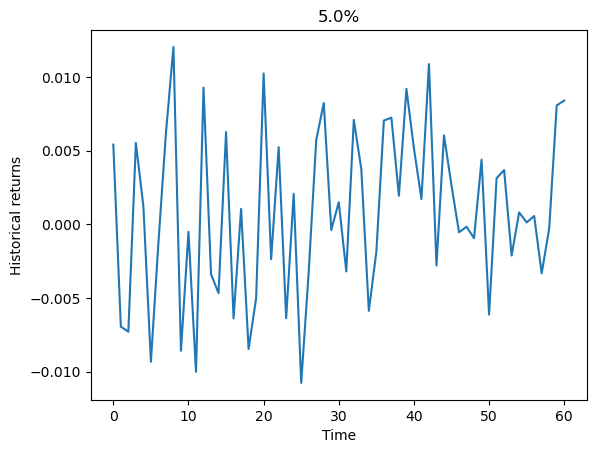

For 10.0%, the optimal weight is  [ 0.0616 -0.0036 -0.0596 -0.0305 -0.1043  0.2528  0.5393  0.0574 -0.0013
  0.1882  0.1   ]
$\mu^T w$: 0.001639344262295082


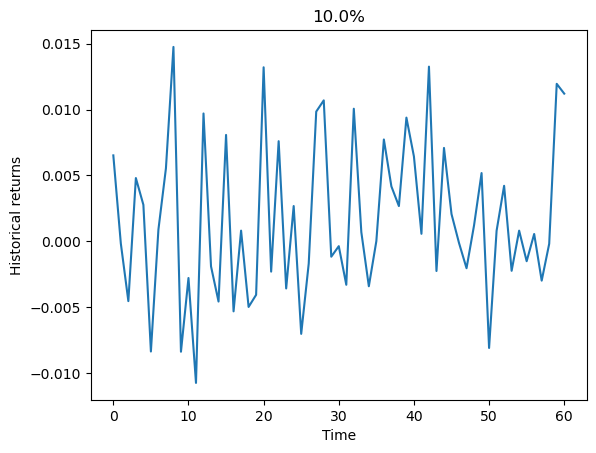

For 20.0%, the optimal weight is  [ 0.0789 -0.0988 -0.1947 -0.1023 -0.1463  0.0807  0.808   0.1868  0.0394
  0.2483  0.1   ]
$\mu^T w$: 0.003278688524590164


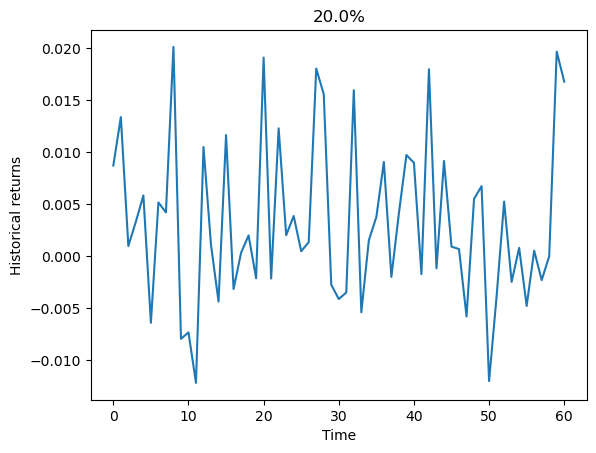

In [7]:
eta_vals = np.array([.05, .10, .20])
rho_vals = eta_vals / T

for rho in rho_vals:
    w = opt_weight(rho)
    print(f"For {rho * T * 100}%, the optimal weight is ", w)
    print(r"$\mu^T w$:", mu @ w)
    plot_return(f"{rho * T * 100}%", opt_weight(rho))

### Part B: Linear Programming

For this part, rather than setting a target mean return, we aim to minimize the risk-return tradeoff with risk-aversion parameter $\lambda > 0$. In particular, we will consider $\lVert Rw - (\mu^T w) {\bf 1} \rVert_1/T$ as a proxy for the risk, instead of using the risk definition from part A. Also, we will only consider long portfolios, i.e. without short-selling. 

5. (5 points) Formulate the above problem of finding the optimal normalized weights as a piecewise linear optimization problem (you can keep the norm expressions explicit for now)

We will only consider long portfolios, i.e. without short-selling. This means that our weight vector must satisfy $w \geq 0$. For a parameter $\lambda > 0$, we want to solve:

$$
\begin{array}{ll}
    \text{minimize} & -\mu^T w + (\lambda / T) \lVert Rw - (\mu^T w) {\bf 1} \rVert_1\\
    \text{subject to} & {\bf 1}^T w = 1\\
    & w \geq 0.
\end{array}
$$

Let $S = {\bf 1} \mu^T \in {\bf R}^{T \times n}$, or the matrix that is a stack of $T$ copies of $\mu^T$. Using this, we can rewrite the optimization problem as

$$
\begin{array}{ll}\tag{2}
    \text{minimize} & -\mu^T w + (\lambda / T) \lVert (R - S)w \rVert_1\\
    \text{subject to} & {\bf 1}^T w = 1\\
    & w \geq 0.
\end{array}
$$

6. (5 points) Formulate this in CVXPY. For 100 values of $\lambda$, logarithmically spaced in the range $[10^{-1}, 10^{2}]$, solve the problem. For each optimal $w$, plot the average daily historical return vs risk for varying $\lambda$.

**Note:** If you choose to use a `cp.Parameter()` for $\lambda$, you will need to pass the flag `nonneg=True` to make the code work. Also, you can use a `np.logspace()` to create the logarithmically spaced $\lambda$ values.

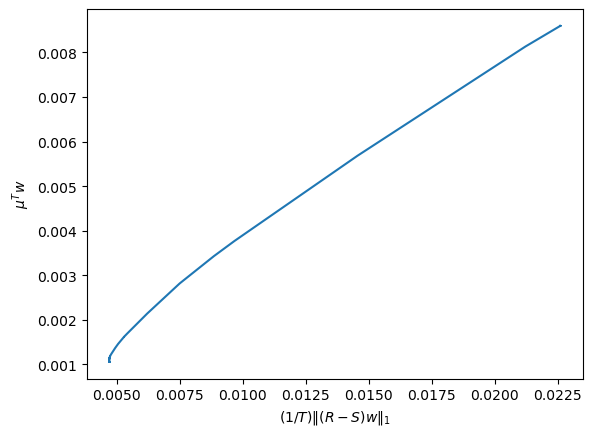

In [8]:
# define S
S = np.kron(mu, np.ones((T, 1)))
T, n = S.shape

# define decision variable
w = cp.Variable(n)

# define constraints
constraints = [w >= 0, cp.sum(w) == 1]

# define lambda space
lambdas = np.exp(np.log(10) * np.linspace(-1, 2, 100))

# define objective
lam = cp.Parameter(nonneg=True)
objective = - (mu @ w) + (lam/T) * cp.norm((R-S) @ w, 1)

# Define problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# list for storing results
returns = []
risks = []

# loop over lambdas and solve for each one
for l in lambdas:
    
    # Assign parameter value
    lam.value = l
    
    # solve it
    problem.solve()

    # store the result
    returns.append(mu @ w.value)
    risks.append((1/T)*cp.norm((R-S) @ w, 1).value)
    
plt.plot(risks, returns)
plt.xlabel(r"$(1 / T) \| (R - S)w \|_1$")
plt.ylabel(r"$\mu^T w$")
plt.show()

7. (5 points) Write this problem as an LP.

8. (5 points) Take the dual of the LP you wrote in question 7.

    **Hint:** you can use the identity $(\mu^T w) {\bf 1} = Sw,$ where 
    $$
    S = \begin{bmatrix}
           - & \mu^T & - \\
             & \vdots &  \\
           - & \mu^T & -
           \end{bmatrix}.
    $$

We introduce auxiliary variable $t \in {\bf R}^n$. Problem (2) can then be written as the following LP:
$$
\begin{array}{ll}
    \text{minimize} & -\mu^T w + (\lambda/T) {\bf 1}^T t \\
    \text{subject to} & (R-S) w \leq t\\
    & (S-R) w \leq t \\
    & {\bf 1}^T w = 1\\
    & w \geq 0.
\end{array}
$$

To aid in taking the dual, we rewrite the LP as

$$
\begin{array}{ll}
    \text{minimize} & -\mu^T w + (\lambda/T) {\bf 1}^T t \\
    \text{subject to} & (R-S) w - t \leq 0\\
    & (S-R) w - t \leq 0\\
    & -w \leq 0\\
    & {\bf 1}^T w = 1.\\
\end{array}
$$

The dual is given by:
$$
\begin{array}{ll}
    \text{maximize} & -y_4 \\
    \text{subject to} & (R-S)^T y_1 + (S-R)^T y_2 - y_3 + {\bf 1}y_4 - \mu = 0\\
    & -y_1 - y_2 + (\lambda/T){\bf 1} = 0 \\
    & y_1, y_2, y_3 \geq 0
\end{array}
$$
Since the final constraint in the primal is an equality constraint, $y_4$ is a free variable in the dual.

9. (5 points) Formulate the dual problem with $\lambda=1$ and solve it in CVXPY. Print the value of the dual variable that corresponds to the primal constraint $w \geq 0$. What does it tell you about the optimal primal variable $w$ and the corresponding stock weights in the portfolio?

In [9]:
S = np.kron(mu, np.ones((T, 1)))
T, n = S.shape
lambd = 1

print('solving dual:')

## dual formulation:
y1 = cp.Variable(T)
y2 = cp.Variable(T)
y3 = cp.Variable(n)
y4 = cp.Variable()

obj = -y4
constraints = [
    (R-S).T @ y1 + (S-R).T @ y2 - y3 + np.ones(n) * y4 - mu == 0,
    -y1 - y2 + (lambd/T) * np.ones(T) == 0,
    y1 >= 0,
    y2 >= 0,
    y3 >= 0,
]
dual = cp.Problem(cp.Maximize(obj), constraints)
dual_res = dual.solve()
print('dual obj:', dual_res)
print('dual var y3 (corresponds to w >= 0):', y3.value)
print(tickers)

solving dual:
dual obj: 0.0035425549103682515
dual var y3 (corresponds to w >= 0): [ 0.      0.0026  0.0056  0.0033  0.003  -0.     -0.      0.      0.0003
  0.      0.0019]
['AMD', 'AMZN', 'BAC', 'GOOG', 'GS', 'K', 'KO', 'META', 'NKE', 'SHEL', 'SPY']


Since $y_3$ has positive values at indices 1, 2, 3, 4, 8, and 10, those corresponding primal $w_i$ must be 0 by complementary slackness. This means AMZN, BAC, GOOG, GS, NKE, and SPY have zero weight in the optimal portfolio. We compute the optimal primal solution below to confirm.

In [10]:
lambd = 1
w = cp.Variable(n)
t = cp.Variable(T)


obj = -mu @ w + (lambd / T) * cp.sum(t)
constraints = [w >= 0, cp.sum(w) == 1, (R-S) @ w <= t, (S-R) @ w <= t]
prob = cp.Problem(cp.Minimize(obj), constraints)
res = prob.solve()
print('primal obj:', res)
print('primal w:', w.value)  # check with the primal to make sure

primal obj: 0.0035425549115160023
primal w: [0.0485 0.     0.     0.     0.     0.221  0.5713 0.0523 0.     0.1069
 0.    ]


### Part C: Integer Programming for sparse allocations

Consider, again, the risk-return trade off minimization problem with the 1-norm defined in Part B. Now, suppose that we are prohibited from holding more than $k$ stocks in our porfolio (i.e. $k < n$).

Again, we will consider the risk-return trade off minimization problem:

$$
\begin{array}{ll}\tag{3}
    \text{minimize} & -\mu^T w + (\lambda / T) \lVert (R - S)w \rVert_1\\
    \text{subject to} & {\bf 1}^T w = 1\\
    & w \geq 0.
\end{array}
$$

10. (6 points) Formulate the new constraint in terms of the *cardinality* of $w$. Then, formulate such constraints using a big-$M$ formulation and add them to the problem. What is the smallest value of $M$ that you can use to encode the cardinality constraints?

We are only allowed to hold at most $k$ stocks in our porfolio (i.e. $k < n$). One way to write this is using a cardinality constraint:

$$
\lVert w \rVert_0 = {\bf card}(w) \leq k.
$$

We can rewrite the cardinality constraint as 
$$ \sum_{i=1}^n t_i \leq k$$
$$0 \leq w_i \leq Mt_i $$
$$t \in \{0,1\}^n $$
The smallest value of $M$ is 1, as we have the constraints ${\bf 1}^T w = 1$,  $w \geq 0$.

11. (7 points) Solve the new integer program with $\lambda = 10$ and $k=5$. Print out the optimal objective value. For the optimal solution, which stocks have nonzero weight?

In [11]:
mu = R.T @ np.ones(T) / T
S = np.kron(mu, np.ones((T, 1)))
b = (1 / n) * np.ones(n)
lambd = 10

w = cp.Variable(n)
t = cp.Variable(n, boolean = True)
obj = -mu.T @ w + (lambd / T) * cp.norm((R - S) @ w, 1)
constraints = [np.ones(n) @ w == 1, w >= 0]
constraints += [cp.sum(t) <= 5, w <= t]
prob = cp.Problem(cp.Minimize(obj), constraints)
# prob.solve(solver=cp.GLPK_MI)
prob.solve()

print("Objective value: ", prob.objective.value)
print("w: ", w.value)
print("The stocks where t is nonzero have nonzero weight. The indices are: ")
print([i for i, e in enumerate(t.value) if e == 1])

Objective value:  0.04599417261421226
w:  [ 0.0727 -0.     -0.     -0.     -0.      0.3587  0.4093  0.0416 -0.
  0.1177 -0.    ]
The stocks where t is nonzero have nonzero weight. The indices are: 
[0, 5, 6, 7, 9]


12. (6 points) Relax the integrality constraints from your formulation in question 11 and solve the corresponding problem in CVXPY. Print out the optimal objective value. For the optimal solution, which stocks have nonzero weight? To account for numerical issues, we will say that a component $w_i$ is nonzero if it is larger than $10^{-8}$.

In [12]:
w = cp.Variable(n)
t = cp.Variable(n)
obj = -mu.T @ w + (lambd / T) * cp.norm((R - S) @ w, 1)
constraints = [np.ones(n) @ w == 1, w >= 0]
constraints += [cp.sum(t) <= 5, w <= t, t <= 1]
prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve()

print("Objective value: ", prob.objective.value)
print("w: ", w.value)
print("The chosen stocks have indices")
print([i for i, e in enumerate(w.value) if e >= 1e-8])

Objective value:  0.045915738656235584
w:  [0.0503 0.     0.     0.     0.     0.2468 0.5084 0.0468 0.0483 0.0993
 0.    ]
The chosen stocks have indices
[0, 5, 6, 7, 8, 9]


13. (6 points) A common way to relax cardinality constraints is to replace it directly with the 1-norm. Perform this relaxation and solve the corresponding problem in CVXPY. Print out the optimal objective value and solution. Did either of these relaxations (this one or the one in question 12) give a better bound on the objective value? Explain your answer.

In [13]:
w = cp.Variable(n)
obj = -mu.T @ w + (lambd / T) * cp.norm((R - S) @ w, 1)
constraints = [np.ones(n) @ w == 1, w >= 0]
constraints += [cp.norm(w,1)<=5]
prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve()

print("Objective value: ", prob.objective.value)
print("w: ", w.value)

Objective value:  0.04591573865639171
w:  [ 0.0503  0.     -0.      0.      0.      0.2468  0.5084  0.0468  0.0483
  0.0993  0.    ]


Neither relaxations constrained the problem further, as the sum of $w$ is already constrained to equal 1. Therefore, components of $w$ were naturally constrained to be $\leq 1$, making the relaxations redundant.

### Part D: Integer programming for sparse trades

Consider, again, the risk-return trade off minimization problem from part B. In this part, suppose that we have a current portfolio allocation $w^{\rm cur}= (1/n){\bf 1}$, i.e., a uniform portfolio with equal weight in all stocks. With the historical data, we want to minimize the risk-return tradeoff, while, at the same time, penalizing trades. In fact, trades can turn out quite expensive if performed too often.

This means we would like to penalize difference between the new portfolio weights and the current ones, i.e., $w - w^{\rm cur}$. In particular, we would like to penalize the number of nonzeros in that difference, which correspond to individual trades. 

14. (6 points) Adjust the problem to enforce a maximum of 5 deviations from $w^\text{cur}$ and formulate it as a mixed-integer LP.

To penalize the deviation, we add the appropriate cardinality constraint $\lVert w - w^\text{cur} \rVert_0 \leq 5$.

To formulate it, we encode the cardinality constraint as:
$$\sum_{i=1}^n t_i \leq 5$$
$$-M t_i \leq (w - w^\text{cur})_i \leq M t_i$$
$$t_i \in \{0, 1\}.$$

It suffices to choose $M = 1 - 1/n$.
The overall mixed-integer LP is:

$$
\begin{array}{ll}
    \text{minimize} & -\mu^T w + (\lambda / T) {\bf 1}^T t\\
    \text{subject to} & (R - S)w \leq t \\
    & (S - R)w \leq t\\
    & {\bf 1}^T w = 1\\
    & w \geq 0 \\
    & \sum_{i=1}^n t_i \leq 5\\
    & -M t_i \leq (w - w^\text{cur})_i \leq M t_i \\
    & t_i \in \{0, 1\}.
\end{array}
$$

15. (6 points) Solve the new problem with CVXPY with $\lambda = 1$, print the average return and risk, and verify that $w-w^\text{cur}$ has at most 5 nonzero values.

In [14]:
mu = R.T @ np.ones(T) / T
S = np.kron(mu, np.ones((T, 1)))
w_cur = (1 / n) * np.ones(n)
lambd = 1

w = cp.Variable(n)
t = cp.Variable(n, boolean=True)
M = 1 - (1 / n)
obj = -(mu @ w) + (lambd / T) * cp.norm((R-S) @ w, 1)
constraints = [
    np.ones(n) @ w == 1,
    w >= 0,
    cp.sum(t) <= 5,
    w - w_cur <= M * t,
    - M * t <= w - w_cur,
]

problem = cp.Problem(cp.Minimize(obj), constraints)
res = problem.solve()

print('average return:', mu @ w.value)
print('risk:', 1/T * np.linalg.norm((R-S) @ w.value, 1))
print('w - w^{cur}:', w.value - w_cur)

average return: 0.0015874813710879284
risk: 0.00612572377904278
w - w^{cur}: [ 0.     -0.0909 -0.0909 -0.0909 -0.0909  0.      0.3636  0.      0.
  0.      0.    ]


16. (6 points) Solving the last problem can take a long time in large dimensions. We would like to solve a similar version that induces sparsity. Replace the hard constraints in problem 14 with a 1-norm penalization in the objective, weighted by coefficient $\beta$. Formulate the problem as a LP.

Removing the cardinality constraints and adding the 1-norm penalization gives:
$$
\begin{array}{ll}
    \text{minimize} & -\mu^T w + (\lambda / T) \lVert (R - S)w \rVert_1 + \beta \lVert w - w^\text{cur} \rVert_1\\
    \text{subject to} & {\bf 1}^T w = 1\\
    & w \geq 0. \\
\end{array}
$$

To formulate this as an LP, we need two auxiliary variables $t$, $z$, which gives:
$$
\begin{array}{ll}
    \text{minimize} & -\mu^T w + (\lambda / T) {\bf 1}^T t + \beta {\bf 1}^T z\\
    \text{subject to} & (R-S)w \leq t\\
    & (S-R)w \leq t \\
    & w - w^\text{cur} \leq z \\
    & w^\text{cur} - w \leq z \\
    & {\bf 1}^T w = 1\\
    & w \geq 0. \\
\end{array}
$$

17. (7 points) Formulate the problem in CVXPY with parameters $\lambda, \beta$. Fix $\lambda = .1$, and solve the problem for 100 logarithmically spaced values of $\beta$ in the range $[10^{-3}, 10^{-2}]$. For each $\beta$ and corresponding optimal solution $w$, plot the number of nonzero values of $w-w^{\rm cur}$ vs. $\beta$, with $\beta$ on a logscale. Again, to account for numerical issues, we will say that a component $(w-w^{\rm cur})_i$ is nonzero if $\lvert (w - w^{\rm cur})_i \rvert \geq 10^{-7}$. What do you notice?

Text(0, 0.5, '${\\bf nnz}(w - w^{\\rm cur})$')

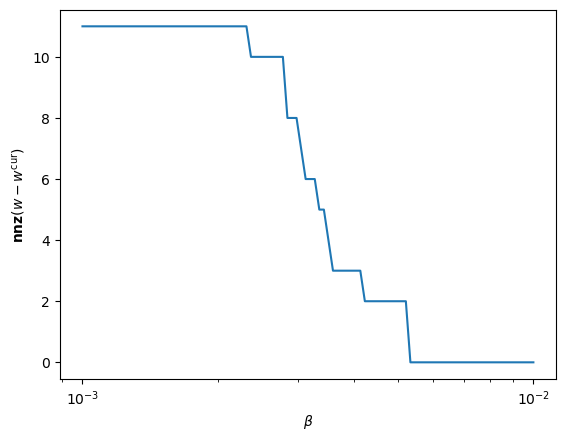

In [15]:
mu = R.T @ np.ones(T) / T
S = np.kron(mu, np.ones((T, 1)))
b = (1 / n) * np.ones(n)  # this is w^{cur}
lambd = .1

beta_vals = np.logspace(-3, -2, num=100)

w = cp.Variable(n)
beta = cp.Parameter(nonneg=True)
obj = -mu.T @ w + lambd / T * cp.norm((R - S) @ w, 1) + beta * cp.norm(w - b, 1)
constraints = [np.ones(n) @ w == 1, w >= 0]
prob = cp.Problem(cp.Minimize(obj), constraints)

nnz = []
for beta_val in beta_vals:
    beta.value = beta_val
    res = prob.solve()
    test = w.value - b
    curr_nnz = (abs(test) > 1e-7).sum()
    nnz.append(curr_nnz)
    
fig, ax = plt.subplots()
nnz = np.array(nnz)
ax.plot(beta_vals, nnz)
plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel(r'${\bf nnz}(w - w^{\rm cur})$')

Generally speaking, as $\beta$ increases, the number of nonzeros decreases, so we can naturally induce sparse solutions by picking $\beta$ to be a large enough number. However, if $\beta$ is picked to be too large, then the number of nonzeros will be 0, which corresponds to $w=b$ as the optimal solution.